Подгружаем необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import os
from keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, SeparableConv2D, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, Dropout, concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping

Визуалзируем одно изображение и соответсвующую ему маску.

In [ ]:
path = 'local\\path'
img = io.imread(path + 'original_images\\001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = io.imread(path + 'label_images_semantic\\001.png', as_gray=True)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(mask)

In [ ]:
print('Image Dimensions are: ', img.shape)
print('Label Dimensions are: ', mask.shape)

Подготовка изображений и меток: изменение размеров и сохранение в один массив.

In [ ]:
X = []
for filename in sorted(os.listdir(path + 'original_images\\')):
    a = io.imread(path + 'original_images\\' + filename)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = cv2.resize(a, (256, 256))
    a = a / 255
    X.append(a)
    
X = np.array(X)

# Prepare the Labels
Y = []
for filename in sorted(os.listdir(path + 'label_images_semantic\\')):
    a = io.imread(path + 'label_images_semantic\\' + filename, as_gray=True)
    a = cv2.resize(a, (256, 256))
    Y.append(a)
    
Y = np.array(Y)

In [ ]:
Yc = to_categorical(Y)

In [ ]:
print(X.shape)
print(Yc.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[1])
axs[1].imshow(Y[1])

In [ ]:
np.save(path + 'original_images', X)
np.save(path + 'masks', Y)
np.save(path + 'masks_categorical', Yc)

Разбиваем датасет на обучающую и проверочную выборки

In [ ]:
test_image1 = X[-1]
test_label1 = Yc[-1]
test_image2 = X[-2]
test_label2 = Yc[-2]
x_train, x_val, y_train, y_val = train_test_split(X[0:-2], Yc[0:-2], test_size = 0.15)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(x_train[50])
axs[1].imshow(np.argmax(y_train[50], axis=2))

Создаём модель U-Net

In [ ]:
def unet(num_classes = 23, image_shape = (256, 256, 3)):
    # Input
    inputs = Input(image_shape)
    
    # Encoder Path
    conv0 = Conv2D(32, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv0 = Conv2D(32, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv0)
    pool0 = MaxPooling2D((2,2))(conv0)
    
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool0)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder Path
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    up10 = Conv2D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv9))
    merge10 = concatenate([up10, conv0], axis = 3)
    conv10 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge10)
    conv10 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv10)
    
    conv11 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv10)
    
    model = Model(inputs, conv11)
    
    return model

In [ ]:
model = unet()
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model_checkpoint = ModelCheckpoint('unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=30)

model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=16, epochs=200,
              callbacks=[model_checkpoint, model_earlyStopping])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [81]:
m1 = test_image1
pred = model.predict(np.expand_dims(m1, 0))
pred_mask = np.argmax(pred, axis=-1)
print(pred_mask.shape)
pred_mask = pred_mask[0]
print(pred_mask.shape)

m2 = test_image2
pred2 = model.predict(np.expand_dims(m2, 0))
pred_mask2 = np.argmax(pred2, axis=-1)
print(pred_mask2.shape)
pred_mask2 = pred_mask2[0]
print(pred_mask2.shape)

(1, 256, 256)
(256, 256)
(1, 256, 256)
(256, 256)


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(np.argmax(test_label1, axis=-1))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask)
axs[2].set_title('Prediction')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m2)
axs[0].set_title('Image')
axs[1].imshow(np.argmax(test_label2, axis=-1))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask2)
axs[2].set_title('Prediction')

Сохраним полученную модель.

In [ ]:
model.save('local\\path\\model_1')

Для загрузки модели пользоваться кодом в следующей ячейке.

In [80]:
from tensorflow import keras
model_1 = keras.models.load_model('local\\path\\model_1')

Создадим новую модель.

In [ ]:
def unet(num_classes = 23, image_shape = (256, 256, 3)):
    # Input
    inputs = Input(image_shape)
    
    # Encoder Path
    conv0 = Conv2D(32, 3, strides=2, padding='same')(inputs)
    batch0 =  BatchNormalization()(conv0)
    act0 = Activation('relu')(batch0)
    prev_block_act0 = act0
    
    conv1 = SeparableConv2D(64, 3, padding='same')(act0)
    batch1 =  BatchNormalization()(conv1)
    act1 = Activation('relu')(batch1)
    
    conv2 = SeparableConv2D(64, 3, padding='same')(act1)
    batch2 =  BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2,2))(batch2)
    
    res2 = Conv2D(64, 1, strides=2, padding='same')(prev_block_act0)
    out2 = Add()([pool2, res2])
    act2 = Activation('relu')(out2)
    prev_block_act2 = act2
    
    conv3 = SeparableConv2D(128, 3, padding='same')(act2)
    batch3 =  BatchNormalization()(conv3)
    act3 = Activation('relu')(batch3)
    
    conv4 = SeparableConv2D(128, 3, padding='same')(act3)
    batch4 =  BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2,2))(batch4)
    
    res4 = Conv2D(128, 1, strides=2, padding='same')(prev_block_act2)
    out4 = Add()([pool4, res4])
    act4 = Activation('relu')(out4)
    prev_block_act4 = act4
    
    conv5 = SeparableConv2D(256, 3, padding='same')(act4)
    batch5 =  BatchNormalization()(conv5)
    act5 = Activation('relu')(batch5)
    
    conv6 = SeparableConv2D(256, 3, padding='same')(act5)
    batch6 =  BatchNormalization()(conv6)
    pool6 = MaxPooling2D((2,2))(batch6)
    
    res6 = Conv2D(256, 1, strides=2, padding='same')(prev_block_act4)
    drop6 = Dropout(0.5)(res6)
    out6 = Add()([pool6, drop6])
    act6 = Activation('relu')(out6)
    prev_block_act6 = act6
    
    # Decoder Path
    conv7 = Conv2DTranspose(256, 3, padding='same')(drop6)
    batch7 =  BatchNormalization()(conv7)
    act7 = Activation('relu')(batch7)
    
    conv8 = Conv2DTranspose(256, 3, padding='same')(act7)
    batch8 =  BatchNormalization()(conv8)
    up8 = UpSampling2D(2)(batch8)
        
    res8 = UpSampling2D(2)(prev_block_act6)
    res8 = Conv2D(256, 1, padding='same')(res8)
    out8 = Add()([up8, res8])
    act8 = Activation('relu')(out8)
    prev_block_act8 = act8
    
    conv9 = Conv2DTranspose(128, 3, padding='same')(act8)
    batch9 =  BatchNormalization()(conv9)
    act9 = Activation('relu')(batch9)
    
    conv10 = Conv2DTranspose(128, 3, padding='same')(act9)
    batch10 =  BatchNormalization()(conv10)
    up10 = UpSampling2D(2)(batch10)
        
    res10 = UpSampling2D(2)(prev_block_act8)
    res10 = Conv2D(128, 1, padding='same')(res10)
    out10 = Add()([up10, res10])
    act10 = Activation('relu')(out10)
    prev_block_act10 = act10
    
    conv11 = Conv2DTranspose(64, 3, padding='same')(act10)
    batch11 =  BatchNormalization()(conv11)
    act11 = Activation('relu')(batch11)
    
    conv12 = Conv2DTranspose(64, 3, padding='same')(act11)
    batch12 =  BatchNormalization()(conv12)
    up12 = UpSampling2D(2)(batch12)
        
    res12 = UpSampling2D(2)(prev_block_act10)
    res12 = Conv2D(64, 1, padding='same')(res12)
    out12 = Add()([up12, res12])
    act12 = Activation('relu')(out12)
    prev_block_act12 = act12
    
    conv13 = Conv2DTranspose(32, 3, padding='same')(act12)
    batch13 =  BatchNormalization()(conv13)
    act13 = Activation('relu')(batch13)
    
    conv14 = Conv2DTranspose(32, 3, padding='same')(act13)
    batch14 =  BatchNormalization()(conv14)
    up14 = UpSampling2D(2)(batch14)
        
    res14 = UpSampling2D(2)(prev_block_act12)
    res14 = Conv2D(32, 1, padding='same')(res14)
    out14 = Add()([up14, res14])
    act14 = Activation('relu')(out14)
    
    outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(act14)
    model = keras.Model(inputs, outputs)
    
    return model

In [79]:
model = unet()
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 128, 128, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 128, 128, 32) 128         conv2d_110[0][0]                 
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 128, 128, 32) 0           batch_normalization_15[0][0]     
_______________________________________________________________________________________

In [ ]:
model_checkpoint = ModelCheckpoint('unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=30)

model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=16, epochs=200,
              callbacks=[model_checkpoint, model_earlyStopping])

In [87]:
history.history

{'loss': [1.9639112949371338,
  1.4112658500671387,
  1.2853729724884033,
  1.2118761539459229,
  1.2547012567520142,
  1.1698758602142334,
  1.1369695663452148,
  1.1326428651809692,
  1.0649996995925903,
  0.9954984784126282,
  1.0686211585998535,
  1.0274989604949951,
  1.0001062154769897,
  0.9327443838119507,
  0.953121542930603,
  0.915152370929718,
  0.9706976413726807,
  0.8942944407463074,
  0.8589599132537842,
  0.8345360159873962,
  0.7900722622871399,
  0.8982427716255188,
  0.8332040905952454,
  0.7681393623352051,
  0.7386691570281982,
  0.7115814685821533,
  0.7336039543151855,
  0.6713558435440063,
  0.6782711148262024,
  0.803227424621582,
  0.814338743686676,
  0.7703953385353088,
  0.6568320989608765,
  0.649552047252655,
  0.6769362092018127,
  0.6472023129463196,
  0.6630484461784363,
  0.6310722827911377,
  0.5894416570663452,
  0.6361830830574036,
  0.5971895456314087,
  0.5584931969642639,
  0.5394951701164246,
  0.6238992214202881,
  0.7429937124252319,
  0.601

In [88]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [94]:
hist_df.iloc[hist_df.val_accuracy.argmax()]

loss            0.389711
accuracy        0.876059
val_loss        0.836668
val_accuracy    0.772951
Name: 73, dtype: float64

Повторим те же действия с новой моделью.

In [ ]:
model.save('local\\path\\model_2')

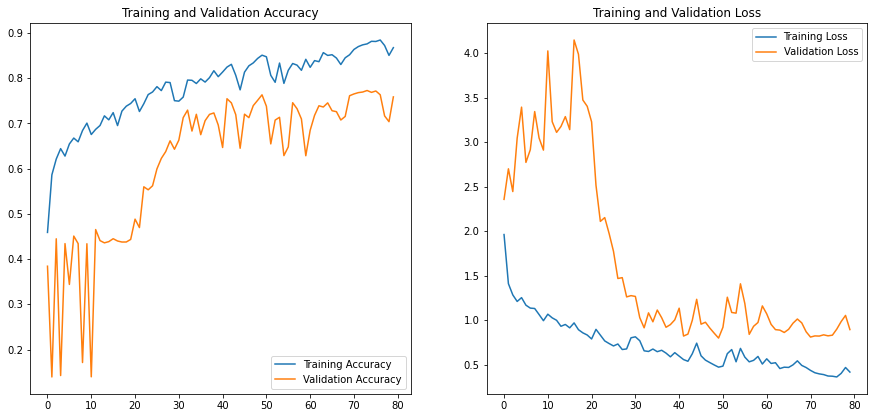

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
m1 = test_image1
pred = model.predict(np.expand_dims(m1, 0))
pred_mask = np.argmax(pred, axis=-1)
print(pred_mask.shape)
pred_mask = pred_mask[0]
print(pred_mask.shape)

m2 = test_image2
pred2 = model.predict(np.expand_dims(m2, 0))
pred_mask2 = np.argmax(pred2, axis=-1)
print(pred_mask2.shape)
pred_mask2 = pred_mask2[0]
print(pred_mask2.shape)

(1, 256, 256)
(256, 256)
(1, 256, 256)
(256, 256)


Text(0.5, 1.0, 'Prediction')

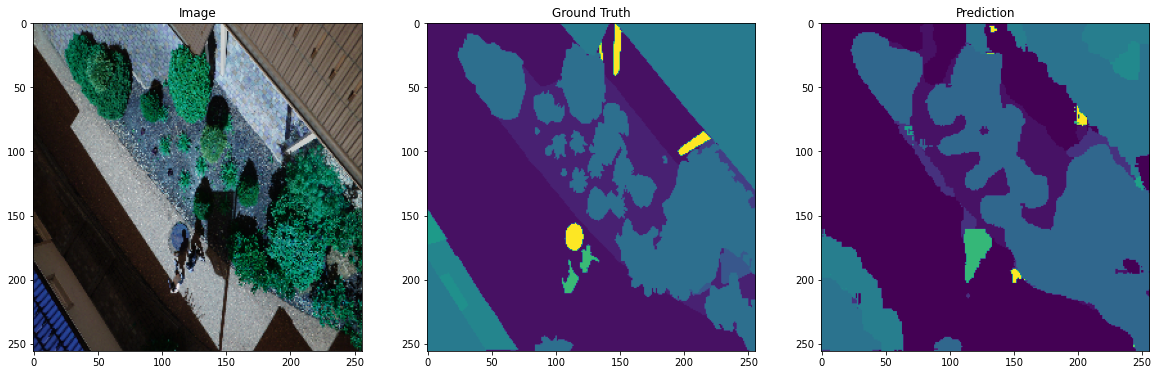

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(np.argmax(test_label1, axis=-1))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask)
axs[2].set_title('Prediction')

Text(0.5, 1.0, 'Prediction')

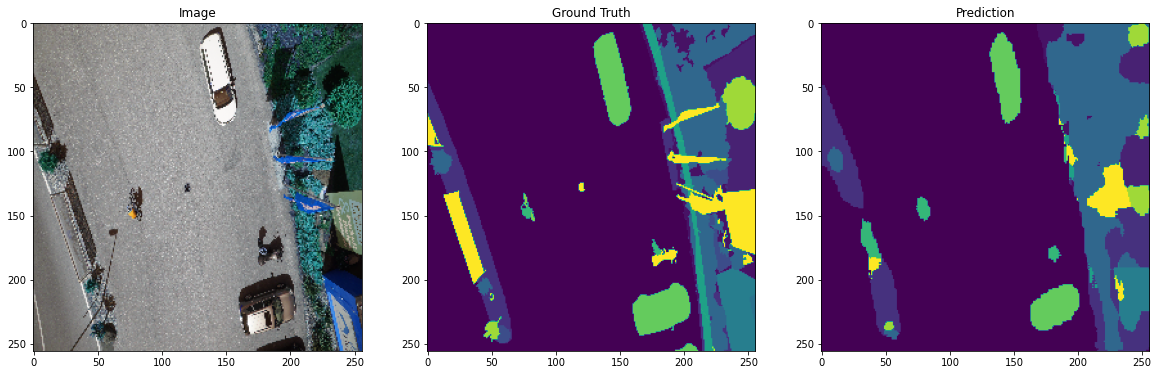

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m2)
axs[0].set_title('Image')
axs[1].imshow(np.argmax(test_label2, axis=-1))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask2)
axs[2].set_title('Prediction')